In [148]:
# import the necessary packages
import numpy as np
import cv2
from matplotlib import pyplot as plt
import imutils

In [149]:
from os import listdir
from os.path import isfile, join
images_paths = sorted([f for f in listdir('images') if isfile(join('images', f))])

In [150]:
def bound_box(image_path):
    # load the image and convert it to grayscale
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    """print(image.shape)
    plt.imshow(gray, 'gray')"""

    # compute the Scharr gradient magnitude representation of the images
    # in both the x and y direction using OpenCV 2.4
    ddepth = cv2.cv.CV_32F if imutils.is_cv2() else cv2.CV_32F
    gradX = cv2.Sobel(gray, ddepth=ddepth, dx=1, dy=0, ksize=-1)
    gradY = cv2.Sobel(gray, ddepth=ddepth, dx=0, dy=1, ksize=-1)
    # subtract the y-gradient from the x-gradient
    gradient = cv2.subtract(gradX, gradY)
    gradient = cv2.convertScaleAbs(gradient)

    #image_derivative = np.maximum(image_horizontal_derivative, image_vertical_derivative)

    """plt.figure()
    plt.imshow(image_horizontal_derivative, 'gray')"""
    
    blurred = cv2.blur(gradient, (9, 9))
    ret2,thresh = cv2.threshold(blurred,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    #kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (20, 20))
    #closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    
    #kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 100))
    #opened = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    
    closed = cv2.erode(closed, None, iterations = 4)
    closed = cv2.dilate(closed, None, iterations = 4)
    
    cnts = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #print(cnts)
    cnts = imutils.grab_contours(cnts)
    c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
    # compute the rotated bounding box of the largest contour
    rect = cv2.minAreaRect(c)
    #print(rect)
    box = cv2.cv.BoxPoints(rect) if imutils.is_cv2() else cv2.boxPoints(rect)
    box = np.int0(box)
    #print(box)
    # draw a bounding box arounded the detected barcode and display the
    # image
    image_bb = image.copy()
    cv2.drawContours(image_bb, [box], -1, (0, 255, 0), 3)
    plt.figure()
    plt.imshow(image_bb, 'gray')
    
    coordinates_source = box.astype('float32')
    min_width = coordinates_source[:,0].min()
    min_height = coordinates_source[:,1].min()
    max_width = coordinates_source[:,0].max()
    max_height = coordinates_source[:,1].max()
    def normalize(value, axis=0):
        if axis==0:  # Horizontal dimension
            return min_width if (value-min_width<max_width-value) \
                             else max_width
        elif axis==1:  # Vertical dimension
            return min_height if (value-min_height<max_height-value) \
                              else max_height
    coordinates_source = np.array(sorted([tuple(v) for v in coordinates_source], key=lambda t: (normalize(t[1], axis=1),
                                                                                                normalize(t[0], axis=0))))
    print(coordinates_source)
    def dist(point1, point2):
        return np.sqrt(np.sum((point1-point2)**2))
    destination_height = int(max([dist(coordinates_source[0],coordinates_source[2]),
                             dist(coordinates_source[1],coordinates_source[3])]))
    destination_width = int(max([dist(coordinates_source[0],coordinates_source[1]),
                             dist(coordinates_source[2],coordinates_source[3])]))
    coordinates_destination = np.array([[0, 0],
                                        [destination_width-1, 0],
                                        [0, destination_height-1],
                                        [destination_width-1, destination_height-1]], dtype='float32')
    # Computing the trasformation, i.e. homography. Warping.
    H = cv2.getPerspectiveTransform(coordinates_source, coordinates_destination)
    # Applying the trasformation
    gray1 = cv2.warpPerspective(gray, H, (destination_width, destination_height))
    plt.figure()
    plt.imshow(gray1, 'gray')

[[ 407.  254.]
 [1277.  249.]
 [ 412. 1136.]
 [1282. 1132.]]
Wall time: 85.7 ms


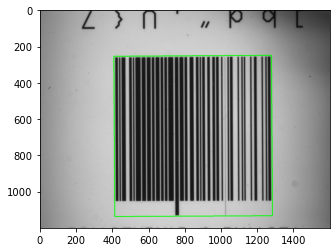

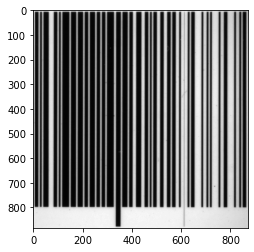

In [151]:
%%time
bound_box(f'images/{images_paths[0]}')

[[ 355.  272.]
 [1230.  272.]
 [ 355. 1089.]
 [1230. 1089.]]
Wall time: 86.4 ms


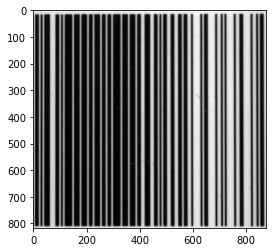

In [152]:
%%time
bound_box(f'images/{images_paths[1]}')

[[ 207.  235.]
 [1023.  230.]
 [ 210.  770.]
 [1027.  766.]]
Wall time: 82.6 ms


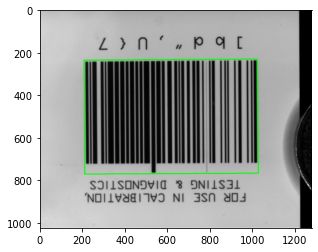

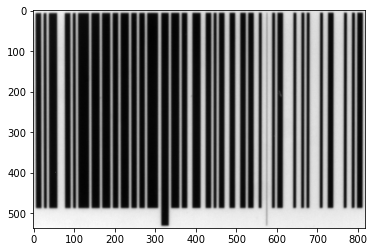

In [153]:
%%time
bound_box(f'images/{images_paths[2]}')

[[137. 251.]
 [954. 251.]
 [137. 744.]
 [954. 744.]]
Wall time: 80.8 ms


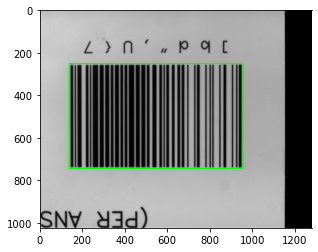

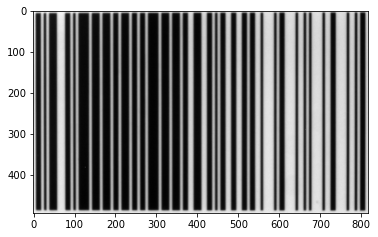

In [154]:
%%time
bound_box(f'images/{images_paths[3]}')

[[343. 165.]
 [886. 165.]
 [343. 735.]
 [886. 735.]]
Wall time: 70.1 ms


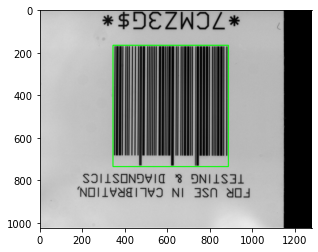

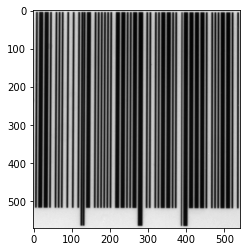

In [155]:
%%time
bound_box(f'images/{images_paths[4]}')

[[350. 243.]
 [895. 243.]
 [350. 768.]
 [895. 768.]]


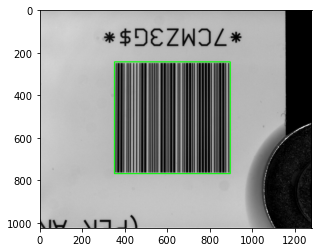

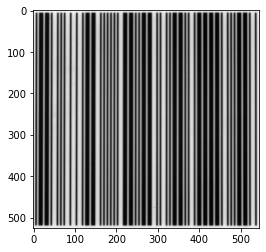

In [156]:
bound_box(f'images/{images_paths[5]}')

In [157]:
bound_box(f'images/{images_paths[6]}')

[[ 170.  281.]
 [1084.  278.]
 [ 172.  852.]
 [1086.  849.]]


In [158]:
bound_box(f'images/{images_paths[7]}')

[[ 158.  267.]
 [1077.  269.]
 [ 157.  792.]
 [1075.  794.]]


[[ 158.  267.]
 [1077.  269.]
 [ 157.  792.]
 [1075.  794.]]


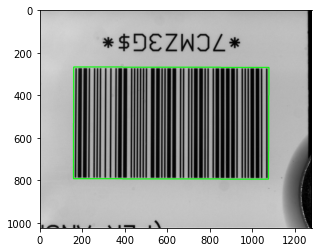

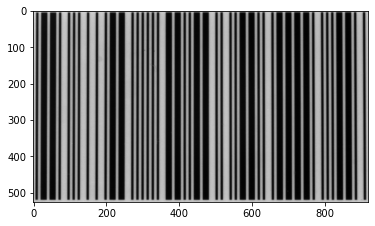

In [159]:
bound_box(f'images/{images_paths[7]}')

[[   0.    0.]
 [1279.    0.]
 [   0.  908.]
 [1279.  908.]]


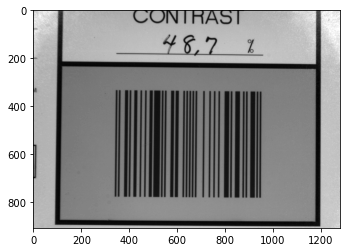

In [160]:
bound_box(f'images/{images_paths[8]}')

[[351. 249.]
 [964. 257.]
 [344. 723.]
 [957. 731.]]


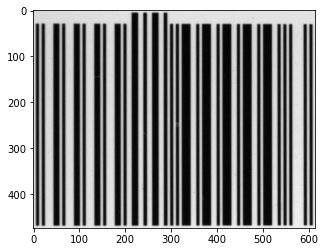

In [161]:
bound_box(f'images/{images_paths[9]}')

In [162]:
print(f'images/{images_paths[10]}')

images/EAN-UPC-DEFECTS IMGB.BMP


In [163]:
#bound_box(f'images/{images_paths[10]}')

[[268. 256.]
 [938. 254.]
 [269. 765.]
 [940. 763.]]


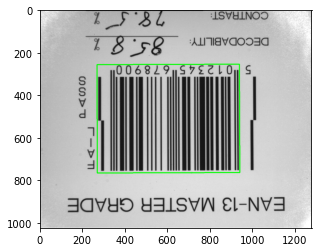

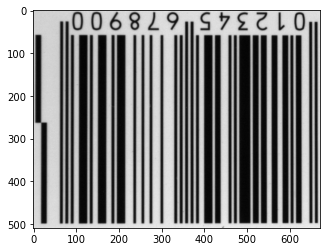

In [164]:
bound_box(f'images/{images_paths[11]}')

In [165]:
#bound_box(f'images/{images_paths[12]}')

[[105. 117.]
 [946. 112.]
 [107. 325.]
 [948. 321.]]


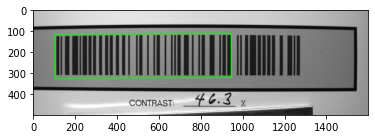

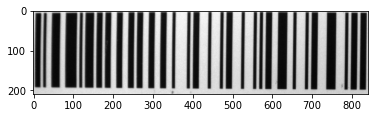

In [166]:
bound_box(f'images/{images_paths[13]}')

[[ 170.  136.]
 [1336.  141.]
 [ 169.  350.]
 [1335.  354.]]


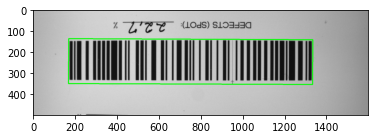

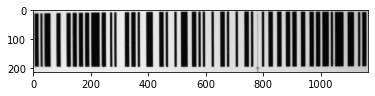

In [167]:
bound_box(f'images/{images_paths[14]}')

[[ 184.  149.]
 [1368.  138.]
 [ 186.  363.]
 [1370.  353.]]


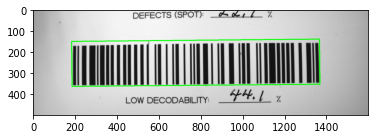

In [168]:
bound_box(f'images/{images_paths[15]}')

In [169]:
bound_box(f'images/{images_paths[16]}')

[[ 208.  135.]
 [1375.  135.]
 [ 208.  335.]
 [1375.  335.]]


[[ 204.  138.]
 [1335.  119.]
 [ 208.  388.]
 [1339.  369.]]


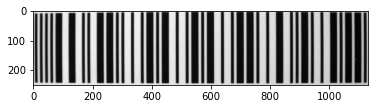

In [170]:
bound_box(f'images/{images_paths[17]}')

[[ 207.  116.]
 [1343.  116.]
 [ 207.  375.]
 [1343.  375.]]


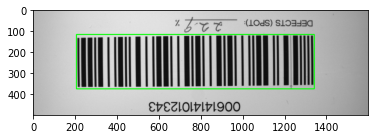

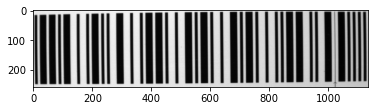

In [171]:
bound_box(f'images/{images_paths[18]}')

[[ 238.   43.]
 [1370.   46.]
 [ 237.  300.]
 [1369.  303.]]


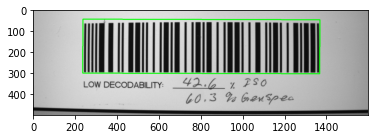

In [172]:
bound_box(f'images/{images_paths[19]}')

[[ 256.  136.]
 [1391.  124.]
 [ 258.  385.]
 [1394.  373.]]


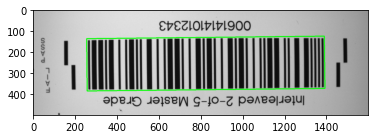

In [173]:
bound_box(f'images/{images_paths[20]}')

In [174]:
print(f'images/{images_paths[21]}')

images/TestChart.xls


In [175]:
#bound_box(f'images/{images_paths[21]}')

[[249. 182.]
 [808. 177.]
 [254. 645.]
 [813. 639.]]


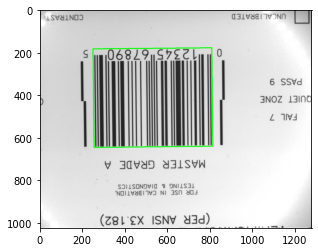

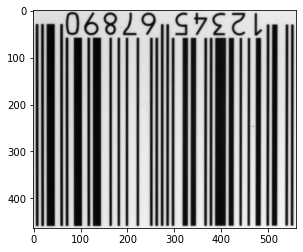

In [176]:
bound_box(f'images/{images_paths[22]}')

[[249. 182.]
 [808. 177.]
 [254. 645.]
 [813. 639.]]


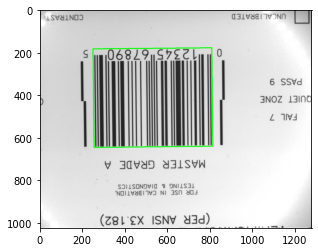

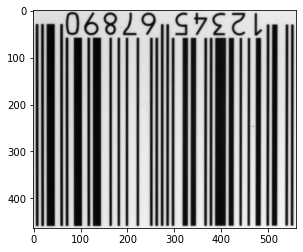

In [177]:
bound_box(f'images/{images_paths[22]}')

In [178]:
bound_box(f'images/{images_paths[23]}')

[[322. 276.]
 [881. 281.]
 [318. 738.]
 [876. 743.]]


[[356. 272.]
 [912. 282.]
 [348. 733.]
 [904. 743.]]


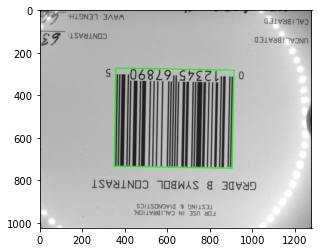

In [179]:
bound_box(f'images/{images_paths[24]}')

[[364. 275.]
 [920. 278.]
 [361. 736.]
 [918. 739.]]


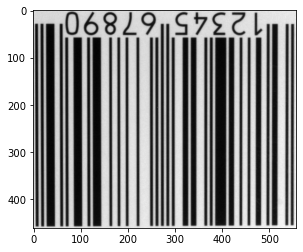

In [180]:
bound_box(f'images/{images_paths[25]}')

[[305. 251.]
 [860. 272.]
 [288. 712.]
 [843. 733.]]


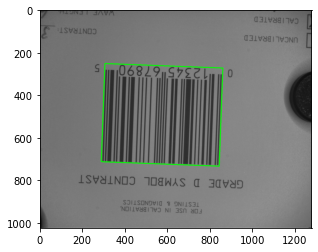

In [181]:
bound_box(f'images/{images_paths[26]}')

In [182]:
bound_box(f'images/{images_paths[27]}')

[[340. 262.]
 [896. 271.]
 [333. 723.]
 [888. 732.]]


[[334. 266.]
 [893. 274.]
 [327. 729.]
 [886. 737.]]


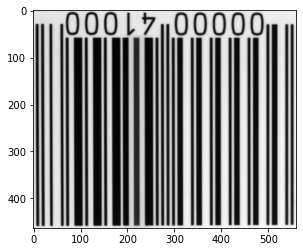

In [183]:
bound_box(f'images/{images_paths[28]}')

[[334. 271.]
 [892. 282.]
 [325. 735.]
 [883. 746.]]


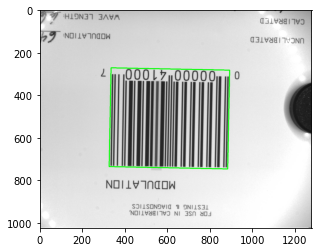

In [184]:
bound_box(f'images/{images_paths[29]}')

In [185]:
bound_box(f'images/{images_paths[30]}')

[[331. 281.]
 [890. 293.]
 [321. 745.]
 [880. 757.]]


[[340. 271.]
 [896. 287.]
 [327. 735.]
 [883. 751.]]


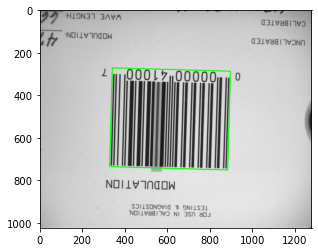

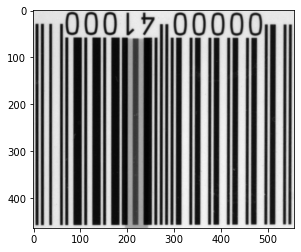

In [186]:
bound_box(f'images/{images_paths[31]}')

[[340. 262.]
 [898. 262.]
 [340. 730.]
 [898. 730.]]


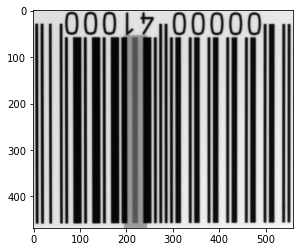

In [187]:
bound_box(f'images/{images_paths[32]}')

[[352. 269.]
 [909. 274.]
 [348. 751.]
 [905. 755.]]


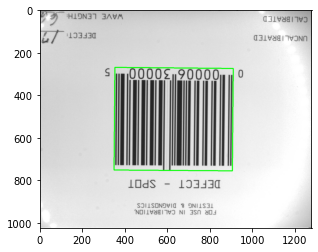

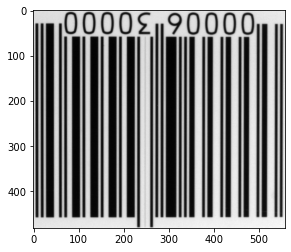

In [188]:
bound_box(f'images/{images_paths[34]}')

[[352. 259.]
 [909. 268.]
 [345. 740.]
 [902. 748.]]


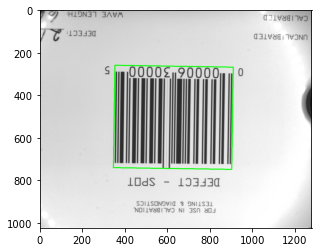

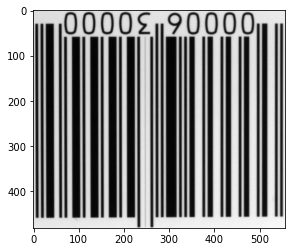

In [189]:
bound_box(f'images/{images_paths[35]}')

[[339. 264.]
 [896. 264.]
 [339. 745.]
 [896. 745.]]


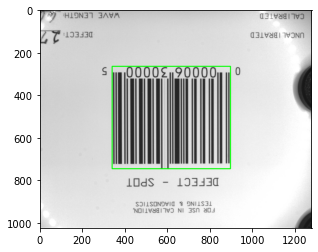

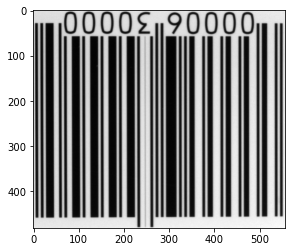

In [190]:
bound_box(f'images/{images_paths[36]}')

[[327. 271.]
 [884. 271.]
 [327. 753.]
 [884. 753.]]


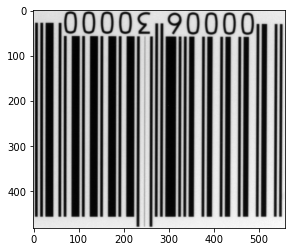

In [191]:
bound_box(f'images/{images_paths[37]}')

[[338. 269.]
 [897. 272.]
 [335. 754.]
 [895. 757.]]


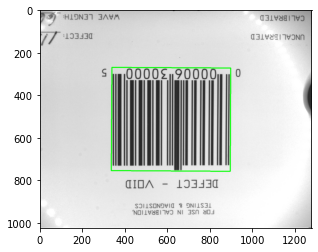

In [192]:
bound_box(f'images/{images_paths[38]}')

[[342. 262.]
 [900. 269.]
 [336. 747.]
 [894. 754.]]


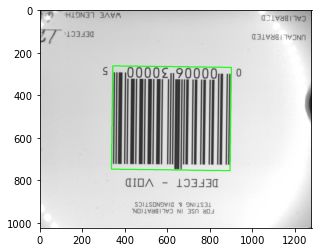

In [193]:
bound_box(f'images/{images_paths[39]}')

In [194]:
bound_box(f'images/{images_paths[40]}')

[[306. 272.]
 [864. 276.]
 [303. 757.]
 [861. 760.]]


[[295. 265.]
 [853. 262.]
 [298. 749.]
 [856. 746.]]


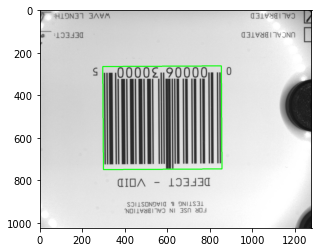

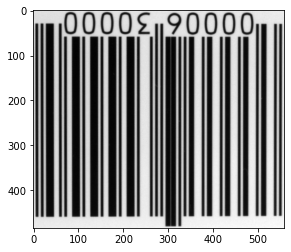

In [195]:
bound_box(f'images/{images_paths[41]}')

In [196]:
bound_box(f'images/{images_paths[42]}')

[[292. 262.]
 [850. 263.]
 [292. 746.]
 [850. 746.]]


In [197]:
bound_box(f'images/{images_paths[43]}')

[[288. 258.]
 [846. 258.]
 [288. 721.]
 [846. 721.]]


[[288. 258.]
 [846. 258.]
 [288. 721.]
 [846. 721.]]


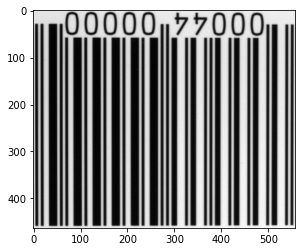

In [198]:
bound_box(f'images/{images_paths[43]}')

[[298. 264.]
 [856. 267.]
 [295. 727.]
 [853. 730.]]


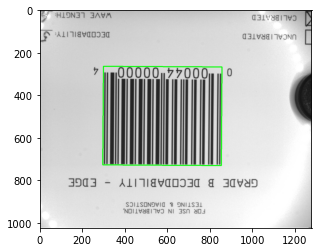

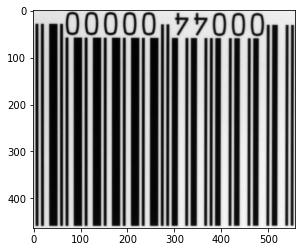

In [199]:
bound_box(f'images/{images_paths[44]}')

[[286. 276.]
 [845. 278.]
 [284. 739.]
 [843. 742.]]


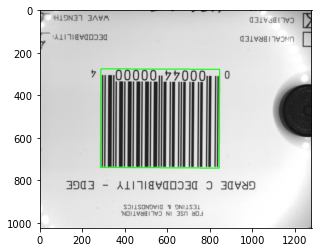

In [200]:
bound_box(f'images/{images_paths[45]}')

[[271. 265.]
 [830. 273.]
 [265. 728.]
 [824. 736.]]


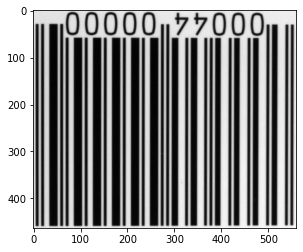

In [201]:
bound_box(f'images/{images_paths[46]}')

[[266. 273.]
 [825. 279.]
 [261. 736.]
 [820. 742.]]


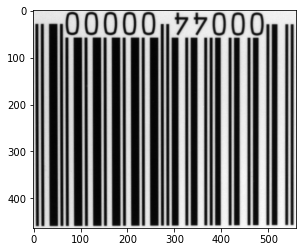

In [202]:
bound_box(f'images/{images_paths[47]}')

[[260. 271.]
 [819. 279.]
 [254. 735.]
 [813. 742.]]


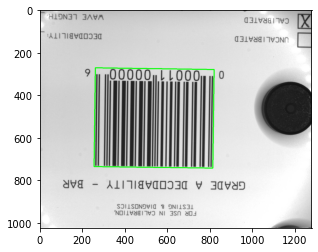

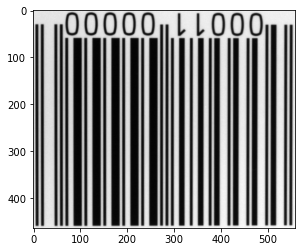

In [203]:
bound_box(f'images/{images_paths[48]}')

[[264. 271.]
 [823. 279.]
 [257. 736.]
 [816. 744.]]


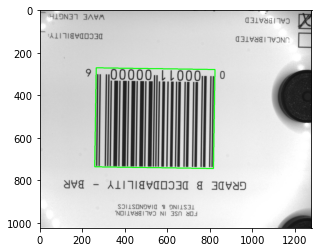

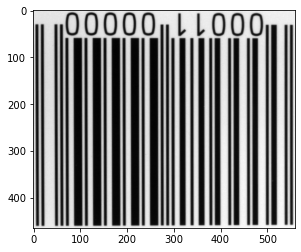

In [204]:
bound_box(f'images/{images_paths[49]}')

[[289. 249.]
 [847. 258.]
 [281. 712.]
 [840. 721.]]


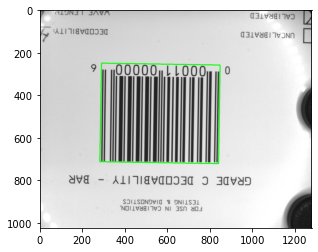

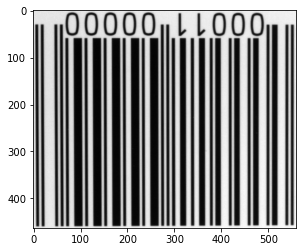

In [205]:
bound_box(f'images/{images_paths[50]}')

[[290. 260.]
 [849. 267.]
 [284. 723.]
 [843. 731.]]


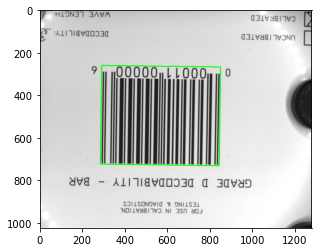

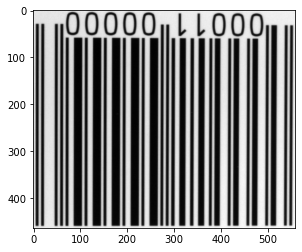

In [206]:
bound_box(f'images/{images_paths[51]}')

[[303. 262.]
 [862. 264.]
 [302. 725.]
 [860. 727.]]


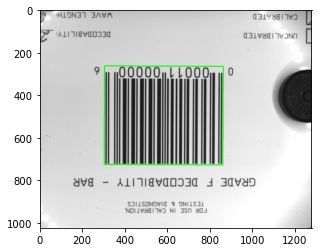

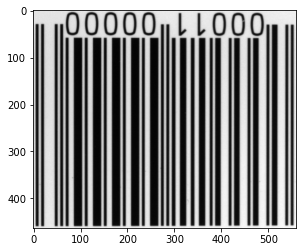

In [207]:
bound_box(f'images/{images_paths[52]}')

[[105.  39.]
 [244.  39.]
 [105. 154.]
 [244. 154.]]
Wall time: 46.8 ms


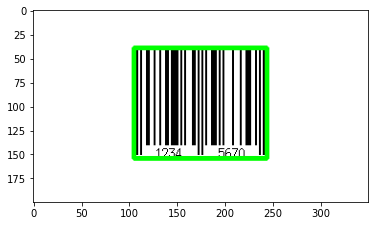

In [208]:
%%time
bound_box('other images/1.png')

In [209]:
%%time
bound_box('other images/2.jpg')

[[   2.  -48.]
 [1609.   10.]
 [  -8.  254.]
 [1598.  313.]]
Wall time: 135 ms


[[ 734. -346.]
 [1744.  406.]
 [ -52.  708.]
 [ 957. 1462.]]
Wall time: 124 ms


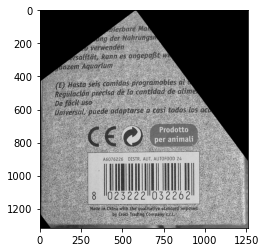

In [210]:
%%time
bound_box('other images/3.jpg')  # NO ROTATION INVARIANCE